# 2017 Kaggle Survey Analysis

[Kaggle](www.kaggle.com) is an online community of data scientists which hosts worldwide contests with cash prizes (e.g. Zillow hosted a contest for improving its pricing algorithm with a $1.2 Million prize and 3,779 teams competing). It's one of the primary learning tools and open data resources available online. In late 2017 they conducted a survey of its users and released the data.

What follows is an example of exploratory data analysis (or EDA). EDA is often the first step in tackling any data science project (that is, after you have the first iteration of your question). This report was created in one of the most prominent industry tools: Juptyer Notebook. Jupyter Notebook lets you write code and Markdown (formated text like what you're reading right now) in one, streamlined document. It's quickly becoming my favorite way to code.

I'll try to explain the code as best as I can as we go. Comments in the code blocks are either preceded by a hash-tag, or are surrounded by three quotes. I geared the comments in the code for a general audience. For the most part, this first big chuck of code creates some reusable functions that take certain kinds of survey questions and plot the responses.

In [1]:
#Importing the usual packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
%matplotlib inline

#Make graphs pretty
sns.set()
sns.set_palette(sns.cubehelix_palette(10, start=1.7, reverse=True))

#Below are functions which I wrote to plot specific types of questions in this survey. The first plots questions like
#which tools do you use at work, select all that apply." The second function plots several questions that are all related,
#such as "How important are the following factors in your job search?" where the answers for each factor are "Not important,
#somewhat important, very important."

#Writing functions like this isn't really necessary, but I found myself writing similar code multple times, which is a good
#clue that you can generalize the code and resuse it multple times, which is basically all a function is.

def select_all_that_apply_plot(df, question, figsize=(12,36)):
    """Takes a dataframe and multiple answer question stem, returns barplot of counts in descending order
    :param df: a DataFrame containing survey results
    :param question_stem: a string containing the question name
    :param figsize: a tuple containing desired figure dimenstions, default = (12,36)
    """
    filtered = pd.DataFrame(df.loc[:,df.columns.str.startswith(question)])
    split = filtered[question].dropna().str.split(',').tolist()
    
    #There has to be a beter way to do this. Nested for loops usually aren't the answer.
    flattened = []
    for i in split:
        for j in i:
            flattened.append(j)
            
    flattened_DF = pd.DataFrame(flattened, columns=[question])
    plt.figure(figsize=(12,6))

    ax = sns.countplot(y=question, data=flattened_DF, order=flattened_DF[question].value_counts().index);
    plt.setp(ax.get_yticklabels(), fontsize=15)
    plt.ylabel('');
    plt.title(question + ', N = ' + str(len(filtered)))
    plt.show()
    
    return

#I ended up not using this function, but left it commented out here just in case. I found that graphing these questions using
#numerical substitutions offered more insight.
'''def multi_plot_from_category(df, question_stem, figsize=(12,36)):
    """Takes a dataframe and a question stem to a multiple-part question, returns barplots of counts
    :param df: a DataFrame containing survey results
    :param question_stem: a string, the leading text of the question
    :param figsize: a tuple containing desired figure dimenstions, default = (12,36)
    """
    #create a new DataFrame made of only the columns we care about
    filtered = pd.DataFrame(df.loc[:,df.columns.str.startswith(question_stem)])
    
    #create a new DataFrame with the counts from the columns of the filtered DataFrame
    counts = pd.DataFrame([filtered[x].value_counts(dropna=True) for x in filtered])
    
    num_columns = len(counts)
    plt.figure(figsize=figsize)
    
    #Create subplots for each question
    for i in range(num_columns):
        plt.subplot(math.ceil(num_columns/4),4,i+1)
        plt.title(counts.index[i][len(question_stem):])
        sns.barplot(x=counts.columns, y=counts.iloc[i])
        plt.ylabel('Count')

    plt.show()
    return'''

def multi_plot_hist(df, question_stem, figsize=(24,18)):
    """Takes a dataframe and a question stem to a multiple-part question, returns histogram of counts. Useful for
    percentage responses.
    :param df: a DataFrame containing survey results
    :param question_stem: a string, the leading text of the question
    :param figsize: a tuple containing desired figure dimenstions, default = (12,36)
    """
    #create a new DataFrame made of only the columns we care about
    filtered = pd.DataFrame(df.loc[:,df.columns.str.startswith(question_stem)]).dropna()
    
    num_columns = len(filtered.columns)
    plt.figure(figsize=figsize)
    
    #Create subplots for each question
    for i in range(num_columns):
        plt.subplot(math.ceil(num_columns/3),3,i+1)
        plt.title(filtered.columns[i][len(question_stem):])
        plt.xlabel('Percentage')
        plt.hist(filtered[filtered.columns[i]], rwidth=0.8)

    plt.show()
    return filtered

def replace_usefulness(df, question_stem):
    """Takes a DataFrame and a question stem. Replaces 'Very Useful' with 1, 'Somewhat Useful with 0.5. and 'Not Useful' with 0
    :param df: DataFrame
    :question_stem: a string containing the quesiton stem"""
    
    #Create a new DataFrame from only the questions we care about
    filtered = pd.DataFrame(df.loc[:,df.columns.str.startswith(question_stem)])
    
    #Replace words with useful numbers
    filtered.replace({
        'Very useful' : 1,
        'Somewhat useful' : 0.5,
        'Not Useful' : 0,
        np.nan : 0
    }, inplace=True)
    
    return filtered

def plot_usefulness_questions(df, question_stem, figsize=(12,36), drop_last=None):
    """Plots a scaled frequency chart for multiple, related questions about usefuless.
    :param df: dataframe
    :param question_stem: a string containing the question stem
    :param figsize: tuple for figure size, default = (12,36)
    :param drop_last: number of questions to drop from the end"""
    
    #Use our replace_usefuless function
    replaced = replace_usefulness(df, question_stem)
    
    #Add up all the values, sort them
    normed = replaced.sum().sort_values(ascending=False)
   
    #Remove the question stem from each row index, leaving only the unique sub-question text
    normed.index=[s[len(question_stem):] for s in normed.index]
    
    #Drop some of the last ones if needed
    if drop_last != None: 
        normed.drop(normed.index[-1*drop_last:], inplace=True)
    
    plt.figure(figsize=figsize)
    ax = sns.barplot(y = normed.index, x = normed)
    plt.setp(ax.get_yticklabels(), fontsize=15)
    plt.title(question_stem + ', N = ' + str(len(replaced)))
    plt.xlabel('Usefulness')
    plt.show()
    
    return normed

#Next two function repeat previous two but for frequency instead of usefulness. 
def replace_frequency(df, question_stem):
    """Takes a DataFrame and a question stem, plots a scaled graph about usefulness.
    :param df: DataFrame
    :question_stem: a string containing the quesiton stem"""
    
    filtered = pd.DataFrame(df.loc[:,df.columns.str.startswith(question_stem)])
    filtered.replace({
        'Most of the time' : 1,
        'Often' : 0.6,
        'Sometimes' : 0.25,
        'Rarely' : 0.1,
        #np.nan : 0
    }, inplace=True)
    
    return filtered

def plot_frequency_questions(df, question_stem, figsize=(12,36), drop_last=None):
    """Plots a scaled frequency chart for multiple, related questions about frequency of use.
    :param df: dataframe
    :param question_stem: a string containing the question stem
    :param figsize: tuple for figure size, default = (12,36)"""
    
    replaced = replace_frequency(df, question_stem)
    normed = replaced.sum().sort_values(ascending=False)
    
    #for i in normed.index:
        #normed[i] = normed[i]/replaced[i].count()
    
                            
    normed.index=[s[len(question_stem):] for s in normed.index]
    if drop_last != None: 
        normed.drop(normed.index[-1*drop_last:], inplace=True)
    
    plt.figure(figsize=figsize)
    ax = sns.barplot(y = normed.index, x = normed)
    plt.setp(ax.get_yticklabels(), fontsize=15)
    plt.title(question_stem + ', N = ' + str(len(replaced)))
    plt.xlabel('Raw Score')
    plt.show()
    
    return normed

#Repeat previous function but for importance.
def replace_importance(df, question_stem):
    """Takes a DataFrame and a question stem. Plots a scaled graph about importance.
    :param df: DataFrame
    :question_stem: a string containing the quesiton stem"""
    
    filtered = pd.DataFrame(df.loc[:,df.columns.str.startswith(question_stem)])
    
    if 'Necessary' in filtered.values:
        replacements = {
            'Necessary' : 1,
            'Nice to have': 0.5,
            'Unnecessary' : 0,
            np.nan : 0
        }
    else:
        replacements = {
            'Very Important' : 1,
            'Somewhat important' : 0.5,
            'Not important' : 0,
            np.nan : 0
        }
    
    filtered.replace(replacements, inplace=True)
    
    return filtered

def plot_importance_questions(df, question_stem, figsize=(12,36), drop_last=None):
    """Plots a scaled frequency chart for multiple, related questions about frequency of use.
    :param df: dataframe
    :param question_stem: a string containing the question stem
    :param figsize: tuple for figure size, default = (12,36)"""
    
    replaced = replace_importance(df, question_stem)
    normed = replaced.sum().sort_values(ascending=False)
                            
    normed.index=[s[len(question_stem):] for s in normed.index]
    if drop_last != None: 
        normed.drop(normed.index[-1*drop_last:], inplace=True)
    
    plt.figure(figsize=figsize)
    ax = sns.barplot(y = normed.index, x = normed)
    plt.setp(ax.get_yticklabels(), fontsize=15)
    plt.title(question_stem + ', N = ' + str(len(replaced)))
    plt.xlabel('Importance')
    plt.show()
    
    return normed


#Importing the multiple choice responses
MC = pd.read_csv('multipleChoiceResponses.csv', encoding='latin-1', low_memory=False)

#Originally I was going to examine the free reponse quesitons as well but decided to leave it for another time.
#FF = pd.read_csv('freeformResponses.csv',encoding='latin-1', low_memory=False)

<br>

## Age of Respondents

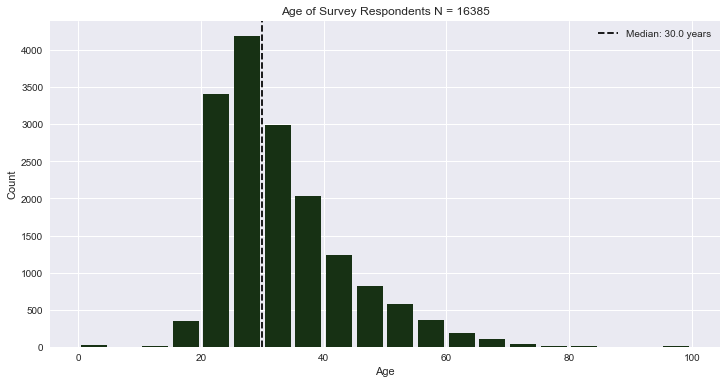

Fraction under 40 years old = 0.778475711893


In [2]:
#Creates a histogram of the Age column of the multiple choice DataFrame (called MC). The 'rwidth' just changes bar width
#to add a little aesthetic space.

MC.Age.hist(bins=20, figsize=(12,6), rwidth=0.85)
plt.axvline(x=MC.Age.median(), color='black', linestyle='--', label='Median: ' + str(MC.Age.median()) + ' years')
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Age of Survey Respondents N = ' + str(MC.Age.count()))
plt.legend(loc='upper right')
plt.show()

fraction_under_40 = MC.Age[MC.Age < 40].count() / len(MC.Age)
print("Fraction under 40 years old = " + str(fraction_under_40))

First, I simply made a histogram of the age of the respondents. The median age is 30 years old. I'm sitting at 34, so pretty close to the middle. As you can see below the chart, almost 78% of respondents are under the age of 40. This reflects a trend we'll see repeated here: we are largely still in the beginning of the data science and big data boom.

<br>

## Compensation

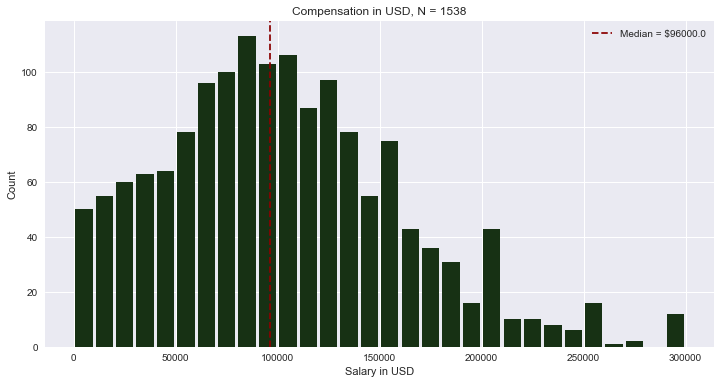

In [3]:
#Isolating dollars
money = MC.CompensationAmount[MC.CompensationCurrency == 'USD']

#Cleaning the data. Some had commas, had to drop the non-answers, and they were all recorded as strings. Also
#some people thought it would be cute to enter 99999999999.
money = money.str.replace(',', '')
money.dropna(inplace=True)
money = pd.to_numeric(money, errors='coerce')
money.sort_values(inplace=True)
money.drop([3013,5939], inplace=True)

#Data is all cleaned, but some people were making half a million dollars, which skewed the chart a lot. So I only graphed
#those making $300K or less. Original amounts are included in the median calculation.
money_median = money.median()
money_less = money[money <= 300000]

#Making the plot
money_less.hist(bins=30, histtype='bar', figsize=(12,6), rwidth=0.85)
plt.axvline(x=money_median, linestyle='--', color='darkred', label='Median = $' + str(money_median))
plt.xlabel('Salary in USD')
plt.ylabel('Count')
plt.title('Compensation in USD, N = ' + str(len(money)))
plt.legend(loc = 'upper right');

Here I had to do a little bit of wrangling. The respondents were from all over the world and thus responded in their local currency. I first needed to isolate those who got paid in dollars. I thought about converting everything, as the conversion rates are included in the downloadable dataset, but since I'm interested in work here in the US, I thought that looking at this subset of respondents made sense.

### How long have respondents been writing data code?

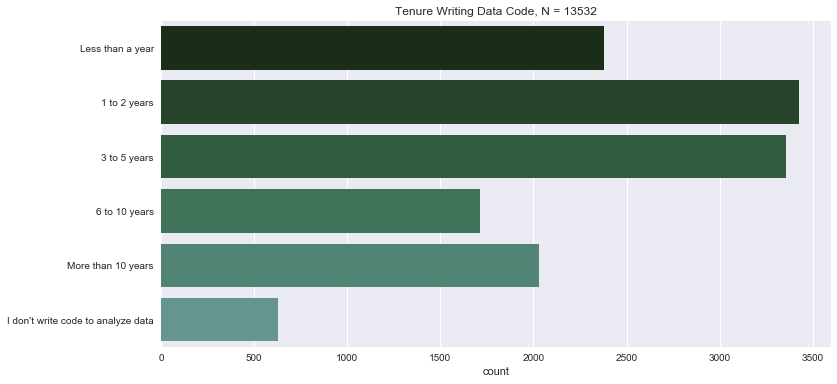

In [4]:
plt.figure(figsize=(12,6))
plt.title('Tenure Writing Data Code, N = ' + str(MC.Tenure.count()))

#A countplot is like a histogram for a discrete range. It just goes through a column, keeping a running tab of the values it finds.
sns.countplot(data=MC, y='Tenure', order=['Less than a year', '1 to 2 years', '3 to 5 years', '6 to 10 years', 'More than 10 years', 'I don\'t write code to analyze data']);
plt.ylabel('');

Here again we see that majority of the respondents are relatively new to the field, with a clear majority having only been writing data-oriented code for less than five years. Companies are realizing the value that a strong data science team can bring, and this trend is moving past the Facebooks and Googles of the tech world.

### How does salary compare to tenure length?

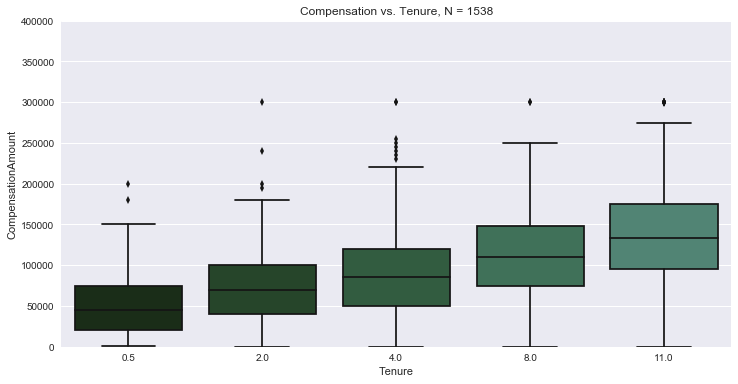

In [5]:
#The actual answers are below in red. Originally I was interested in a linear regression of the data, so I used the values
#below to replace the text answers. In the end, I thought the boxplots gave a better impression of the data, but I left
#replacement values there for future use.

replacements = {
    "I don't write code to analyze data" : np.nan,
    "1 to 2 years" : 2,
    "3 to 5 years" : 4,
    "6 to 10 years" : 8,
    "Less than a year" : 0.5,
    "More than 10 years": 11
}
x_tenure = MC.Tenure.replace(replacements)[money_less.index].dropna()
y_money = money_less[x_tenure.index]
plt.figure(figsize=(12,6))
sns.boxplot(x_tenure, y_money)
plt.ylim(0, 400000)
plt.title('Compensation vs. Tenure, N = ' + str(len(money)))
plt.show();

Next, I wanted to compare how long people have been writing code to how much money they make. Below is a series of boxplots. A boxplot is a way to visualize the distribution of data. The central box comprises the central 50% of the data, with the dark line in the middle marking the median. The 'whiskers' represent the outer range, with outliers plotted as points beyond. Notice the nice upward trend. I made the same plot with age instead of tenure, and the trend was much less pronounced. I'm still only looking at dollar-earners here.

## Education

Here we'll look at how data scientists learned what they know. Which platforms did they use and how useful were they? Etc.

### Which level of formal education have you attained?

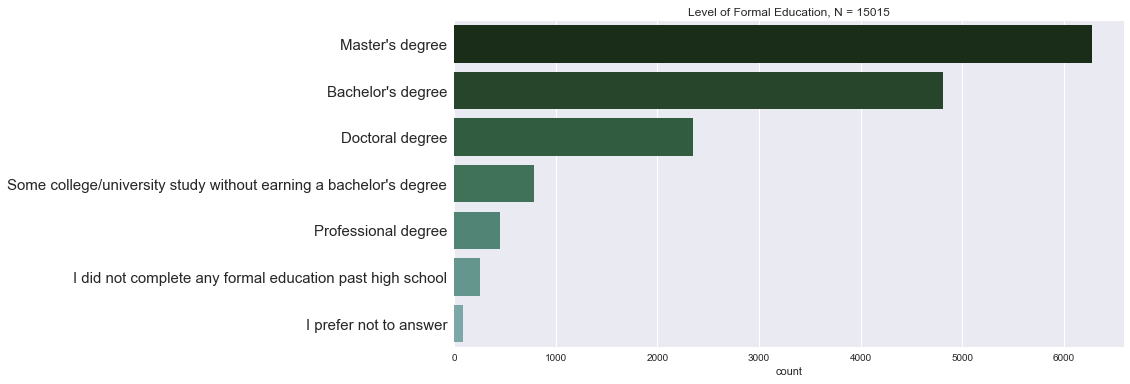

Fraction of respondents with more than a Bachelor's degree: 0.515673606126


In [6]:
plt.figure(figsize=(12,6))
ax = sns.countplot(y='FormalEducation', data=MC, order=MC['FormalEducation'].value_counts().index)
plt.setp(ax.get_yticklabels(), fontsize=15)
plt.ylabel('')
plt.title('Level of Formal Education, N = ' + str(MC.FormalEducation.count()))
plt.show()

#This adds up the number of people who have a Masters and a PhD, then divides by the total.
fraction_higher_bachelors = (MC['FormalEducation'].value_counts()['Master\'s degree']
 + MC['FormalEducation'].value_counts()['Doctoral degree'])/len(MC.FormalEducation)
print('Fraction of respondents with more than a Bachelor\'s degree: ' + str(fraction_higher_bachelors))

Just over half of the respondents have more than a Bachelor's degree. I technically fall into this category, although my MS in the History and Philosophy of Science is largely tangential to the field. The survey did not ask about the fields in which these degrees were earned, only the undergraduate. One of my remaining questions about all of this is whether or not I need more official credentials. Do I need to get an MS in data science? Should I use one of the online bootcamps? Or will I competitive if I'm completely self-taught?

<br>

### How did you first start your machine learning / data science training? 

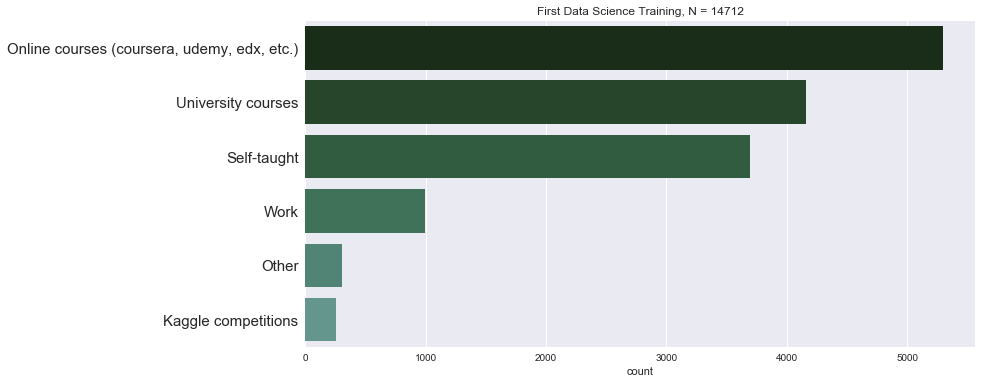

In [7]:
plt.figure(figsize=(12,6))
plt.title('First Data Science Training, N = ' + str(MC.FirstTrainingSelect.count()))
ax = sns.countplot(y='FirstTrainingSelect', data=MC, order=MC['FirstTrainingSelect'].value_counts().index)
plt.setp(ax.get_yticklabels(), fontsize=15)
plt.ylabel('');
plt.show()

<br>
This chart is pretty hopeful to me since most of the respondents first learned online or are self-taught. What this data doesn't show is how many of those who *first* started online stayed *only* online. How many ended up getting a MS in data science or went to a bootcamp?

<br>

### How useful did you find these platforms & resources for learning data science skills?

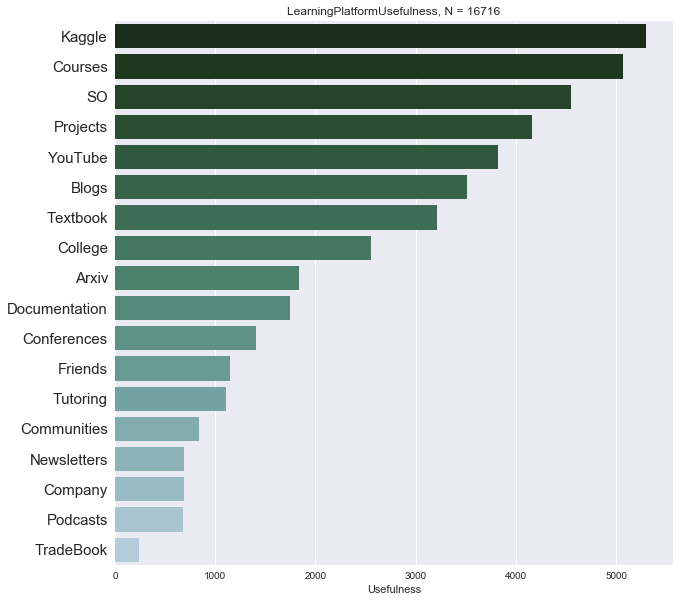

In [8]:
#Here I am using one of the functions I wrote in the first block of code. It uses some numeric replacements for text responses to get
#a good idea of the overall usefulness of a platform.
sns.set_palette(sns.cubehelix_palette(20, start=1.7, reverse=True))
plot_usefulness_questions(MC, 'LearningPlatformUsefulness', figsize=(10,10));

This chart is pretty useful. The question asked about the usefulness of various learning platforms. Combined with the previous chart, you can get a sense for the progression of an average data scientist's eduction. Notice that online courses rank high on both charts, meaning that they are used from the beginning are found to be very useful. But look at Kaggle. Kaggle is ranked as the most useful learning platform out there (granted, these are all Kaggle users, so they might be a little biased, but they are also some of the best data scientists in the world). But Kaggle competitions is ranked *last* among the first places people went to learn. So Kaggle is an amazing resource for learning the trade, but it's probably better to tackle the competitions after someone gets their feet wet in other ways.

<br>

### What percentage of your current machine learning / data science training falls under each category? 

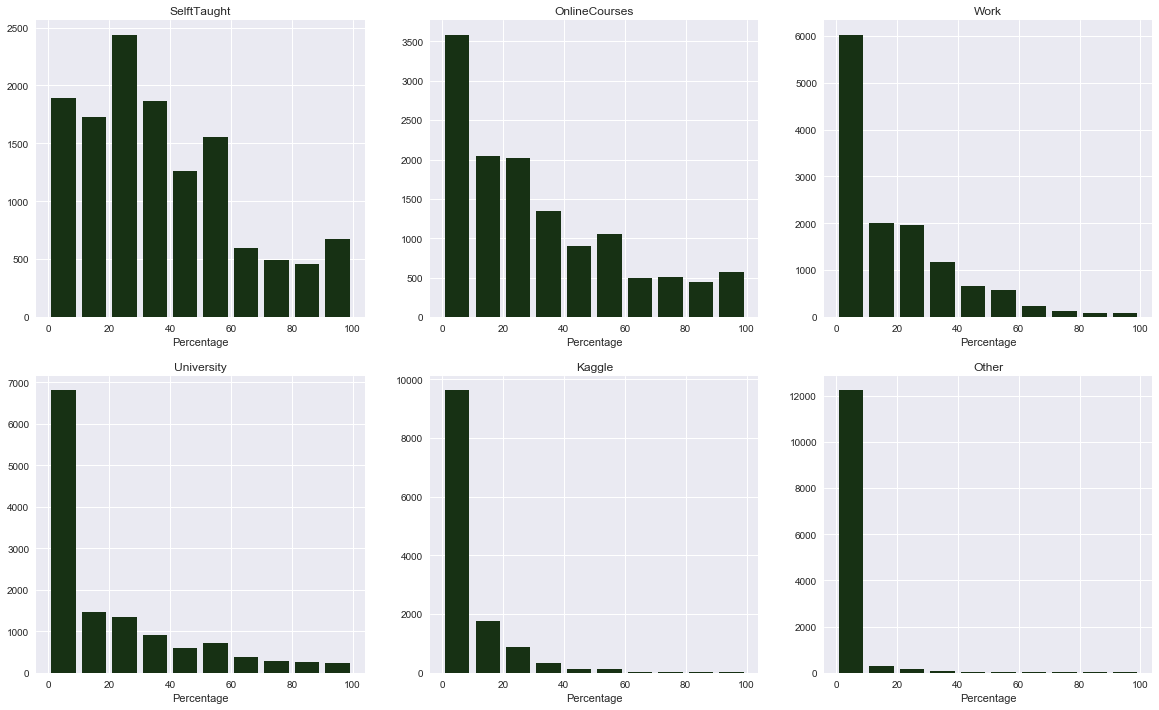

In [9]:
#This is the primary question I wrote the histogram function above. I thought there might be another questions to use it with, but it wasn't as useful.
filt = multi_plot_hist(MC, 'LearningCategory', figsize=(20,12));

This question asked respondents to divide up their current data science training into percentages across these six categories. Above are the histograms of these responses. From the first graph, for example, around 700 people put 100% of their learning into 'Self Taught'. From these charts, it seems that people don't really stick around Kaggle forever. Almost 10,000 repondants said they don't use Kaggle at all for learning currently.

<br>

### What's the most important way you can prove your knowledge of machine learning / data science?

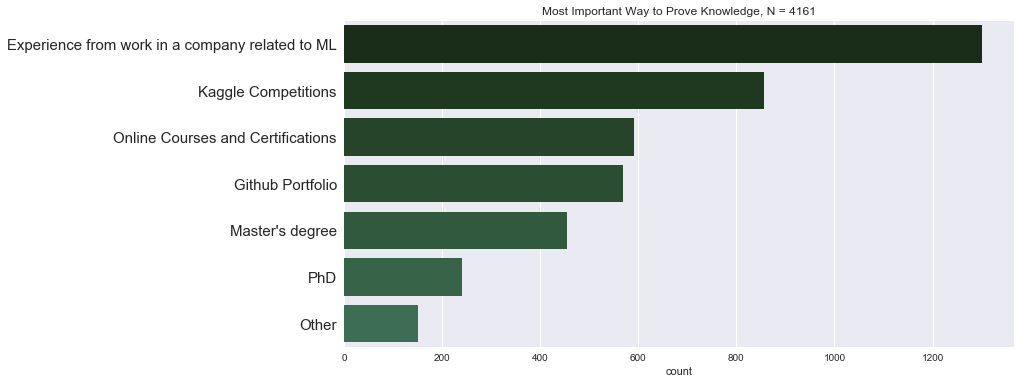

In [10]:
plt.figure(figsize=(12,6))
plt.title('Most Important Way to Prove Knowledge, N = ' + str(MC.ProveKnowledgeSelect.count()))
ax = sns.countplot(data=MC, y='ProveKnowledgeSelect', order=MC['ProveKnowledgeSelect'].value_counts().index)
plt.setp(ax.get_yticklabels(), fontsize=15)
plt.ylabel('');

<br><br>
This next chart is interesting to me too. Respondents who are learning data science were asked about the best way to prove their knowledge of machine learning and data science. As expected, the most common answer was work experience. Of course, I will be running into the age-old problem of how to get experience without experience. But the second most frequent response is Kaggle competitions. The chief data scientist of a local data science firm here in Jacksonville mentions his Kaggle ranking as one of his qualifications on the company website. So perhaps this isn't far from the truth.

## The Data Scientist's Career

In this next section we'll look at the tools, methods, and challenges that data scientists encounter in their careers.

### Which industry is your current employer/contract in?

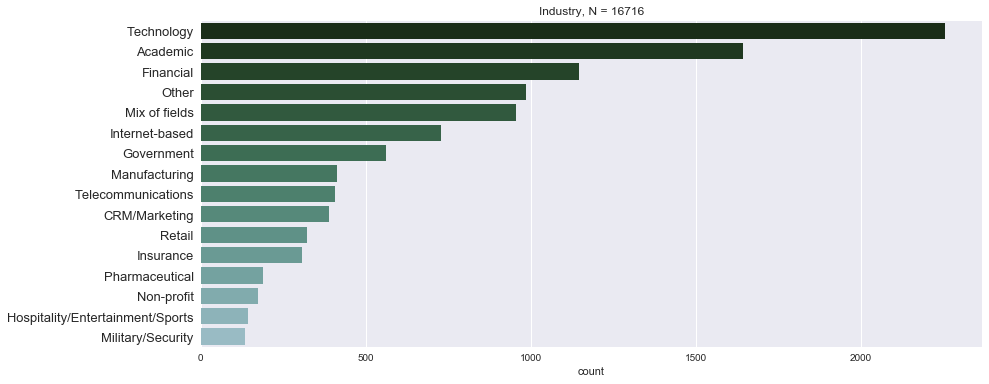

In [11]:
sns.set_palette(sns.cubehelix_palette(20, start=1.7, reverse=True))
plt.figure(figsize=(14,6))
plt.title('Industry, N = ' + str(len(MC.EmployerIndustry)))
ax = sns.countplot(y='EmployerIndustry', data=MC, order=MC['EmployerIndustry'].value_counts().index)

#This is the only way I figured out how to change the labels on the y-axis.
plt.setp(ax.get_yticklabels(), fontsize=13)
plt.ylabel('')
plt.show()

The industry in which the respondents work. Notice that 'Other' and 'Mix of fields' are fourth and fifth. This tells me that data science is spreading to all corner of the marketplace.

### What is the primary function of your role?

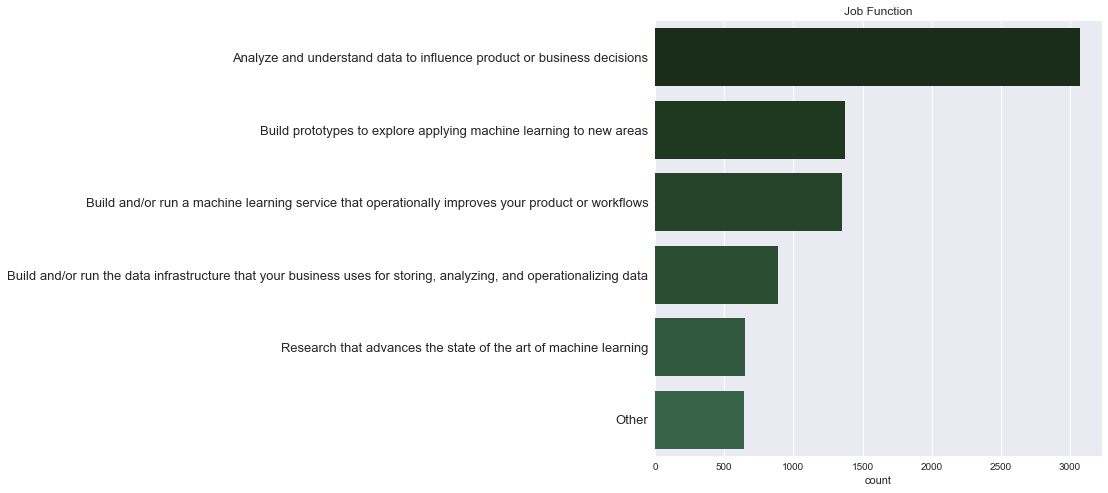

In [12]:
plt.figure(figsize=(8,8))
plt.title('Job Function')
ax = sns.countplot(y='JobFunctionSelect', data=MC, order=MC['JobFunctionSelect'].value_counts().index)
plt.setp(ax.get_yticklabels(), fontsize=13)
plt.ylabel('');

By a factor of two, the most common function for data scientists is to 'Analyze and understand data to influence product or business decisions.' (I couldn't figure out a good way to make this graph pretty. I could have replaced all the responses with shortened versions of them before counting, but I thought they were more informative in their original form.)

<br>

### For work, which data science/analytics tools, technologies, and languages have you used in the past year?

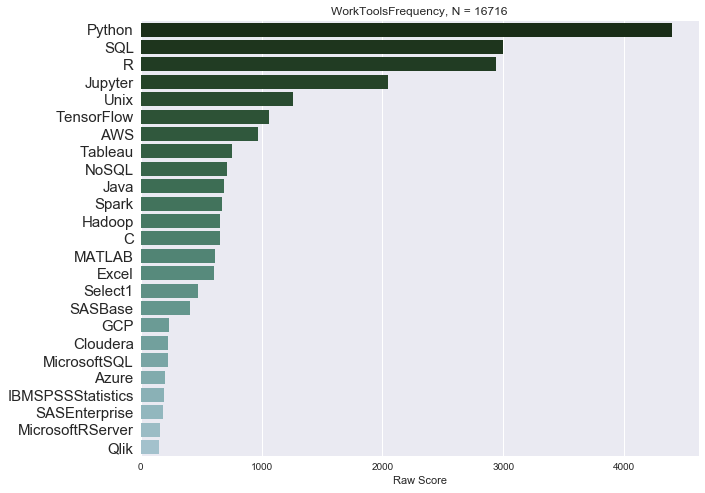

In [13]:
sns.set_palette(sns.cubehelix_palette(30, start=1.7, reverse=True))
plot_frequency_questions(MC, 'WorkToolsFrequency', figsize=(10,8), drop_last=25);

The chart is made using the frequency question function we wrote in the first block of code. It uses the following translation:
>'Most of the time' = 1 <br>
'Often' = 0.6 <br>
'Sometimes' = 0.25 <br>
'Rarely' = 0.1 <br>

This is fairly arbitrary, but it will give us a rough sense of the frequency of a tool. I decided not to normalize this data. So many respondents only answered a small number of these questions, and I am unsure as how to best interpret that. Do I take a blank as a 'never'? That means I should divide by the entire number of respondents, but when I do so, Python doesn't even break 30% and R doesn't break 20%. I'm pretty sure two primary languages are used more prevalently than that. So I left the raw score as is. It should still give us a strong indication of the relevant use of these tools.

<br>

### At work, which data science methods do you use?

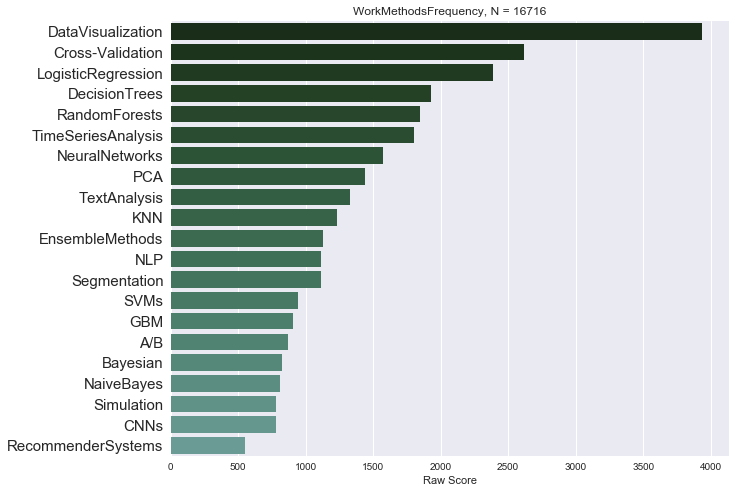

In [14]:
sns.set_palette(sns.cubehelix_palette(35, start=1.7, reverse=True))
plot_frequency_questions(MC, 'WorkMethodsFrequency', figsize=(10,8), drop_last = 12);

This is graphed using the same frequency function as Data visualization is the front runner by a long shot, with some of the most basic machine learning tools coming next. I know the gist behind a lot of these, but I still have a long way to go in my level of understanding. (See the question below about level of algorithm understanding for more!)

<br>

### How important do you think the below skills or certifications are in getting a data science job?

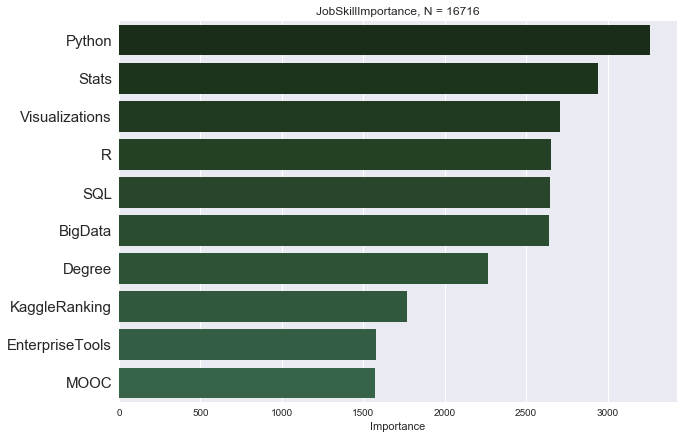

In [15]:
df = plot_importance_questions(MC, 'JobSkillImportance', figsize=(10,7), drop_last=3)

This question was only asked to those currently learning data science. They match up fairly well with the tools and methods used in the industry. I notice that SQL is 2nd on the tools used by work, but only fifth in the learners' perception (SQL, pronounced 'sequel', is the primary language used for interacting with relational databases). I plan on learning SQL as soon as I'm done with DataCamp's curriculum. The numerical translation of the text I used is:
> 'Necessary' = 1 <br>
'Nice to have' = 0.5 <br>
'Unnecessary' = 0

### What programming language would you recommend a new data scientist learn first?

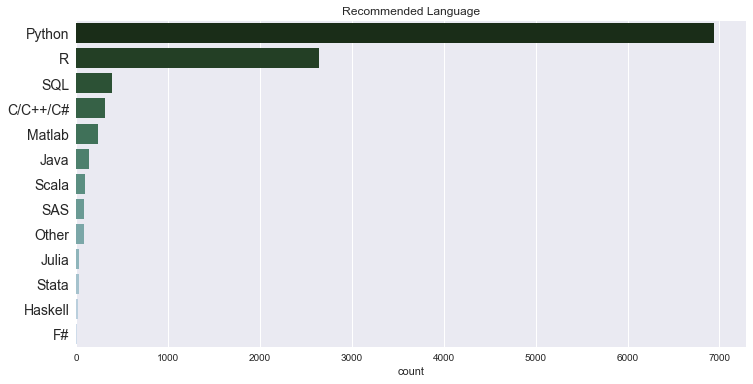

In [16]:
plt.figure(figsize=(12,6))
plt.title('Recommended Language')
sns.set_palette(sns.cubehelix_palette(13, start=1.7, reverse=True))
ax = sns.countplot(data=MC, y='LanguageRecommendationSelect', order=MC['LanguageRecommendationSelect'].value_counts().index);
plt.ylabel('')
plt.setp(ax.get_yticklabels(), fontsize=14);

Python by a long shot! R is still the favorite of the statistician and many academics, but with Python's ability to be a full-stack language and its readability, it is quickly becoming the industry standard. I've really enjoyed Python so far and am glad I chose to learn it first!

<br>

### Which resource has been the best for finding data science job openings? 

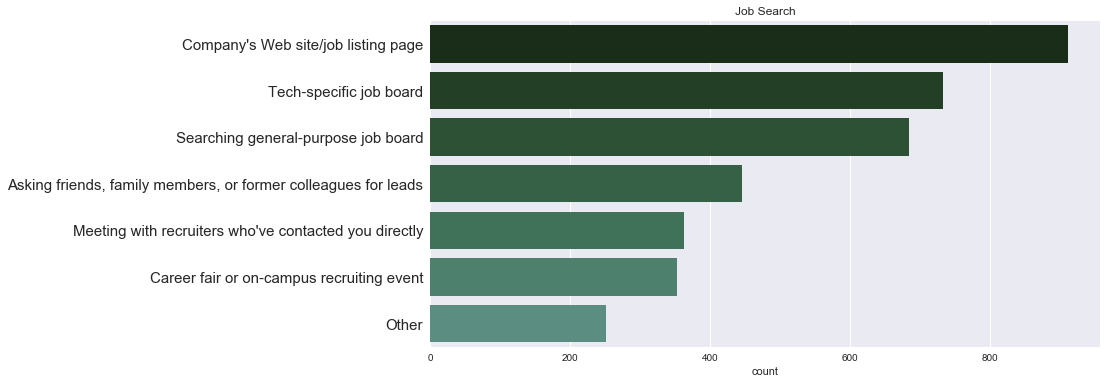

In [17]:
plt.figure(figsize=(12,6))
plt.title('Job Search')
ax = sns.countplot(y='JobSearchResource', data=MC, order=MC['JobSearchResource'].value_counts().index)
plt.setp(ax.get_yticklabels(), fontsize=15)
plt.ylabel('');

Not too many surprises here. It's interesting to me that going to specific companies' websites seems to be more fruitful than searching general places like LinkedIn. Good to know!

<br>

### In which areas of machine learning do you consider yourself competent? Select all that apply.

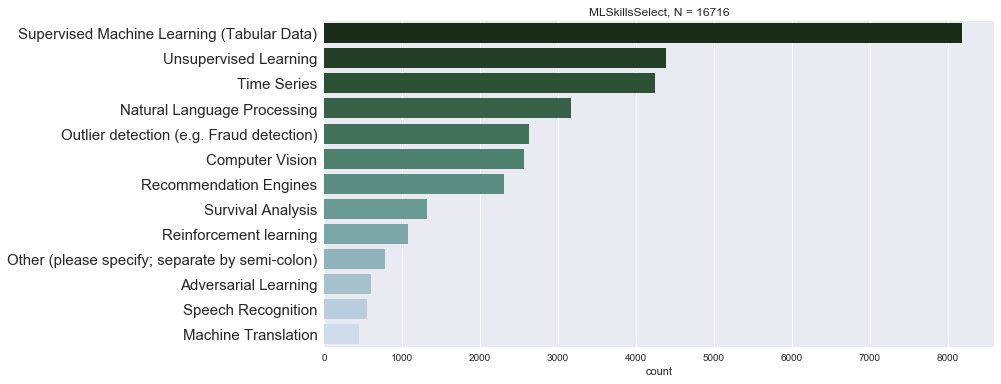

In [18]:
sns.set_palette(sns.cubehelix_palette(13, start=1.7, reverse=True))
select_all_that_apply_plot(MC, 'MLSkillsSelect', figsize=(10,8))

This chart is interesting to me. Do the differences here reflect the supply or the demand? It seems like computer vision (processing images) and natural language processing (analyzing text) would be more prominent. It makes me wonder if I should try to specialize a bit in some of these under-served areas to make myself more marketable.

<br>

### At which level do you understand the mathematics behind the algorithms you use at work?

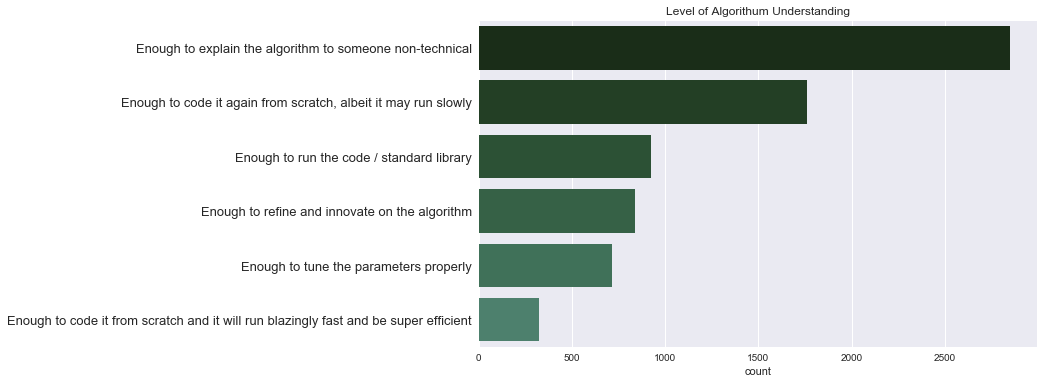

In [19]:
plt.figure(figsize=(10,6))
plt.title('Level of Algorithum Understanding')
ax = sns.countplot(y='AlgorithmUnderstandingLevel', data=MC, order=MC['AlgorithmUnderstandingLevel'].value_counts().index);
plt.setp(ax.get_yticklabels(), fontsize=13)
plt.ylabel('');

This chart is pretty helpful to me. One of the main questions I still have is about the depth I should be learning some of this material. Do I need to get pretty deep in the weeds? Or should I have the gist down enough to walk someone through it? The actual level of understanding that pertains to these various answers is debatable (e.g. to me, to be able to explain it properly requires more understanding than being able to tune the parameters or even code it from scratch, but I'm not sure if that's what the respondents meant). In general, though, the fact that I don't need to understand enough to innovate the algorithm or be able to write a blazing version gives me some hope that I learn most of this on my own.

<br>

### At work, how often did you experience these barriers or challenges within the past year?

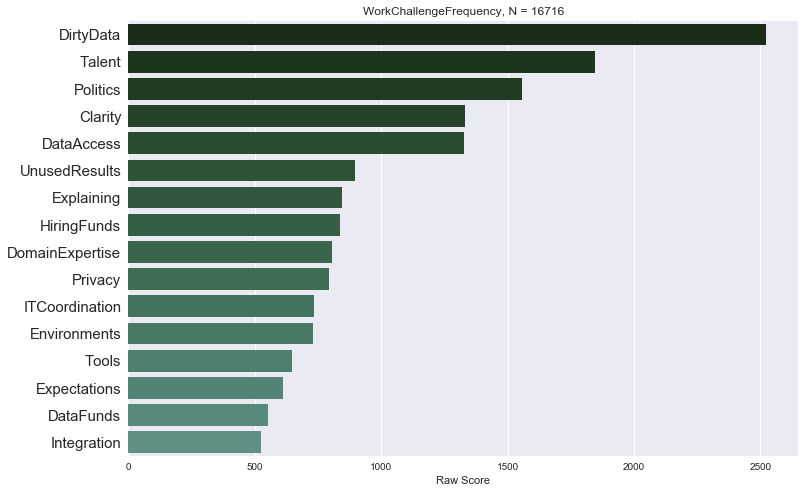

In [20]:
sns.set_palette(sns.cubehelix_palette(30, start=1.7, reverse=True))
plot_frequency_questions(MC, 'WorkChallengeFrequency', figsize=(12,8), drop_last=6);

Out of the top eight challenges at work, only two technical, with 'Dirty Data' taking the lead by far. Most of the other challenges seem to be managerial: clarity of goals, explaining results, unused results, office politics, etc. I can only imagine that dirty data will be mitigated over time. As we build better and better tools for scrubbing data, and as we begin to collect raw data in better forms, will these other challenges rise to the top? This chart used the numeric estimates for frequency.

<br>

### How are you assessing potential job opportunities?

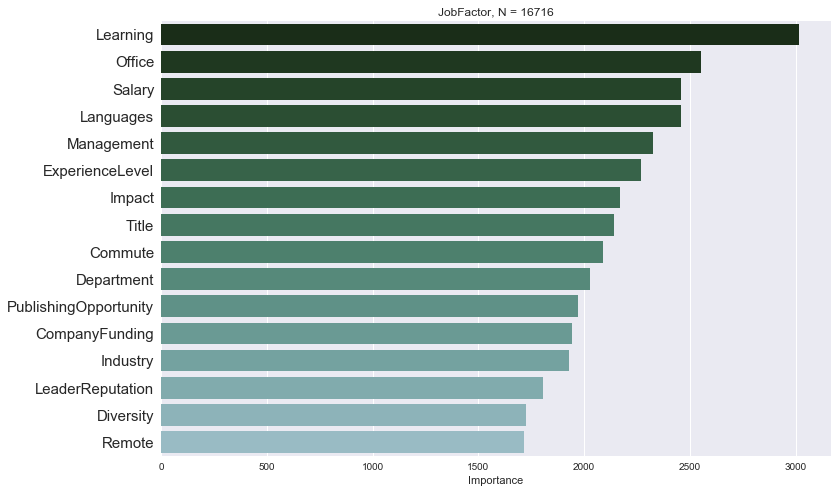

In [21]:
sns.set_palette(sns.cubehelix_palette(20, start=1.7, reverse=True))
plot_importance_questions(MC, 'JobFactor', figsize=(12,8));

This question was asked of those respondents who are actively learning data science. The continued opportunity for professional development ("Learning" on the chart) was the most important factor, while office environment, salary, and programming languages not far behind. Notice that the actual industry in which someone will be working tended not to be very important. Data scientists just want data, and they don't care much where they get it. Here is the numerical translation:
>'Very Important' = 1 <br>
'Somewhat important' = 0.5 <br>
'Not important' = 0

<br>

### Do you currently consider yourself a data scientist?

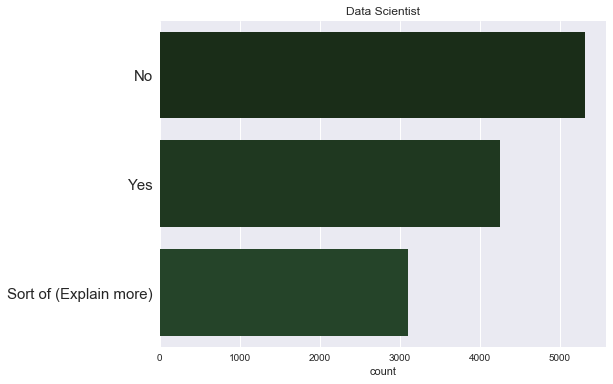

In [22]:
plt.figure(figsize=(8,6))
plt.title('Data Scientist')
ax = sns.countplot(y='DataScienceIdentitySelect', data=MC, order=MC['DataScienceIdentitySelect'].value_counts().index);
plt.setp(ax.get_yticklabels(), fontsize=15)
plt.ylabel('');

This chart is super interesting to me. In [this episode](https://talkpython.fm/episodes/show/139/paths-into-a-data-science-career) of the Talk Python To Me podcast, Hugo Bowne-Anderson from DataCamp talks about imposture syndrome (where one believes he or she doesn't belong), and it's prevalent here as well. When asked if respondents currently consider themselves a data scientist, most said no or sort of! I've definitely felt over my head and too far behind several times over the past few months. Part of me believes this is all just a pipe dream. It's nice to see others think so too! Or, maybe that's not nice to see? We'll see! I plan to analyze more of the free response sections of this survey in a future post, and this 'Sort of' answer will probably be interesting to explore.

<br>

### How many years has your organization been utilizing advanced analytics/data science?

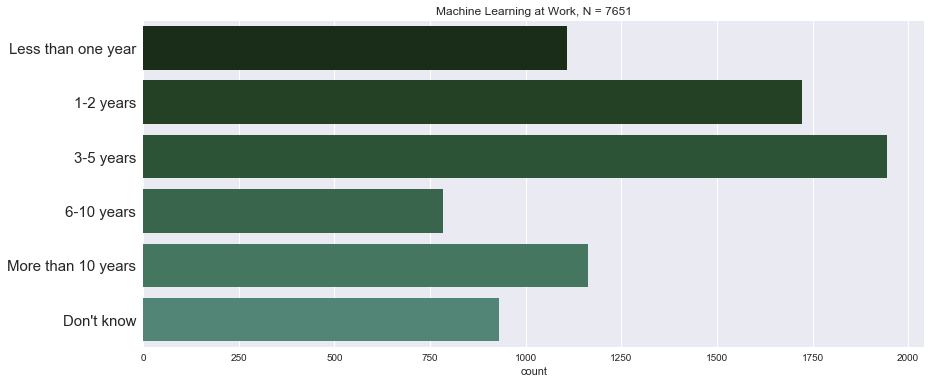

In [23]:
plt.figure(figsize=(14,6))
sns.set_palette(sns.cubehelix_palette(12, start=1.7, reverse=True))
plt.title('Machine Learning at Work, N = ' + str(MC.EmployerMLTime.count()))
ax = sns.countplot(y='EmployerMLTime', data=MC, order=[
    'Less than one year',
    '1-2 years',
    '3-5 years',
    '6-10 years',
    'More than 10 years',
    'Don\'t know'
]);
plt.ylabel('')
plt.setp(ax.get_yticklabels(), fontsize=15);

This chart shows the length of time that current data coding scientists' workplace has been using machine learning. Here again we see that most companies have only been using machine learning for 5 years or less! Hopefully I'm not too late!

<br>

### On a scale from 0 (Highly Dissatisfied) - 10 (Highly Satisfied), how satisfied are you with your current job?

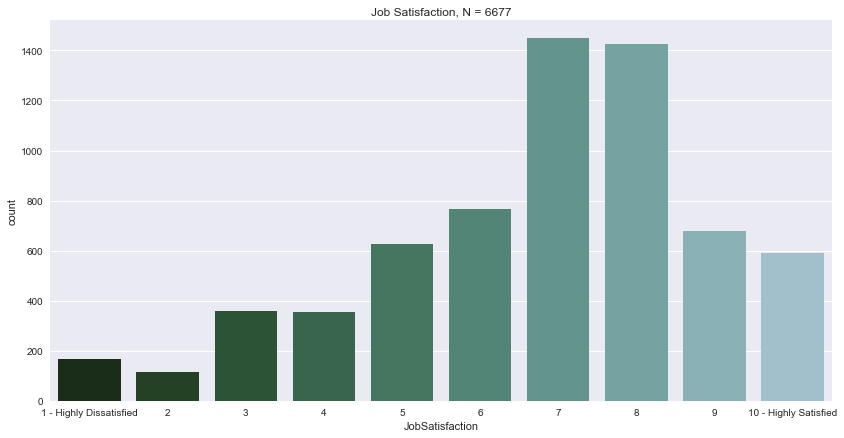

In [24]:
plt.figure(figsize=(14,7))
plt.title('Job Satisfaction, N = ' + str(MC.JobSatisfaction.count()))
plt.ylabel('')
sns.countplot(x='JobSatisfaction', data=MC,
     order=[
         '1 - Highly Dissatisfied',
         '2',
         '3',
         '4',
         '5',
         '6',
         '7',
         '8',
         '9',
         '10 - Highly Satisfied',
     ]);


And last but perhaps most importantly, job satisfaction. This question was also asked of current code workers. I feel that I could be good at this job and that I would enjoy it immensely. Most of the respondents are very satisfied with what they're doing. Hopefully I'll be in those ranks soon!

# Conclusion

The main takeaway I have is that I'm on the right track. I'm learning the right language and the right methods. Many data scientists currently employed have traveled a similar career track as my own (or at least they, like me, have mostly taught themselves or used online courses). I don't think it's too late to get into the field: it's young, people are excited about learning it, and companies are just beginning to take advantage of what data science can offer. Data scientists are generally satisfied with their job and well compensated. Nothing I've really seen so far has discouraged me from entering this field. I know that Big Data has a dark side, and privacy issues abound, but the data community is thinking hard about these issues. I look forward to contributing to these conversations.

Any feedback about this report is welcome!